# **Sign Language Recognition** 
[*Greneter Cordoves Delgado*](mailto:greneter@cicese.edu.com)

## Libraries and Packages 

In [221]:
import common
import os
import sys
import cv2
from glob import glob
import glob
from tqdm.notebook import tqdm_notebook
import pandas as pd
import numpy as np
import mediapipe as mp
from joblib import dump
from skimage import io

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import seaborn as sns
from IPython.display import Image

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Definition of functions

In [168]:
def view_img(sign): 
    images = dataset_df.loc[dataset_df['Sign'] == sign]
    reqd_Index = dataset_df[dataset_df['Sign'] == sign].index.tolist()   
    
    fig = plt.figure(figsize=(20, 2))      
    for i in range(10):
        plt.subplot(1, 10, i+1)    
        plt.title('Sign: {} '.format(sign), size=10)
        plt.axis('off')
        image = images['Path']
        img = io.imread(image[reqd_Index[i]])
        plt.imshow(img)

## Loading dataset

In [169]:
# Root folder where to look for jpg files
root_folder = ".\dataset"

# Pattern to search for jpg files in all subdirectories
pattern = os.path.join(root_folder, "**\\**\\*.jpg")

# Search for files matching the pattern
jpg_files = glob.glob(pattern, recursive=True)

file_sign_label = []
file_sign_path = []

# Paths and labels to the files found
for path in tqdm_notebook(jpg_files):
    part = os.path.basename(path)
    part = part.split('.')[0]  
    label = part.split('-')[0]
    file_sign_label.append(label)
    file_sign_path.append(path)    

# Creating dataframe
sign_df = pd.DataFrame(file_sign_label, columns=['Sign'])
path_df = pd.DataFrame(file_sign_path, columns=['Path'])
dataset_df = pd.concat([sign_df, path_df], axis = 1) 

  0%|          | 0/1497 [00:00<?, ?it/s]

In [170]:
# Creating CSV file 
dataPath = pd.concat([dataset_df], axis = 0)
dataPath.to_csv("gesture_dataset.csv", index = False);
dataPath.head()

,Sign,Path
0,A,.\dataset\S1\A\A-1-1.jpg
1,A,.\dataset\S1\A\A-1-16.jpg
2,A,.\dataset\S1\A\A-1-33.jpg
3,A,.\dataset\S1\A\A-2-31.jpg
4,A,.\dataset\S1\A\A-2-52.jpg


## Data Visualisation and Exploration

In [171]:
count_sign = dataset_df.groupby('Sign').count().reset_index()
sign = np.array(count_sign['Sign'])
count_sign

,Sign,Path
0,A,300
1,E,300
2,I,300
3,O,300
4,U,297


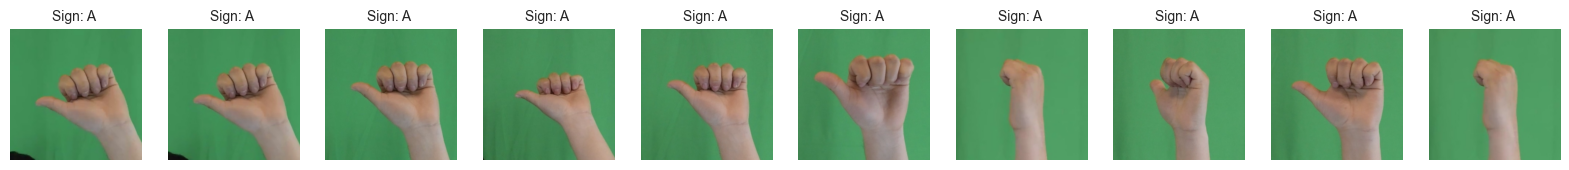

In [172]:
sign='A'
view_img(sign)

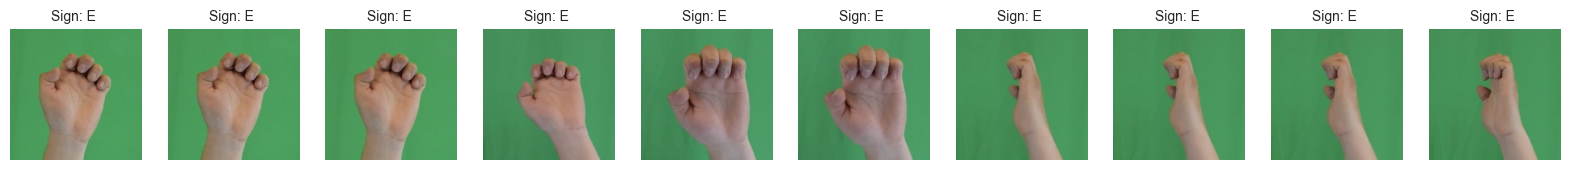

In [173]:
sign='E'
view_img(sign)

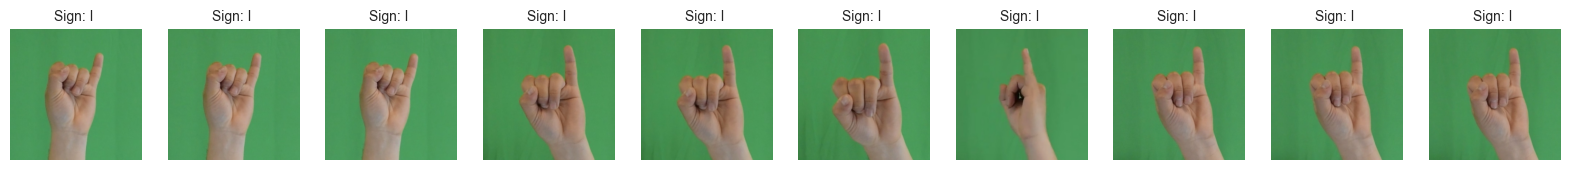

In [174]:
sign='I'
view_img(sign)

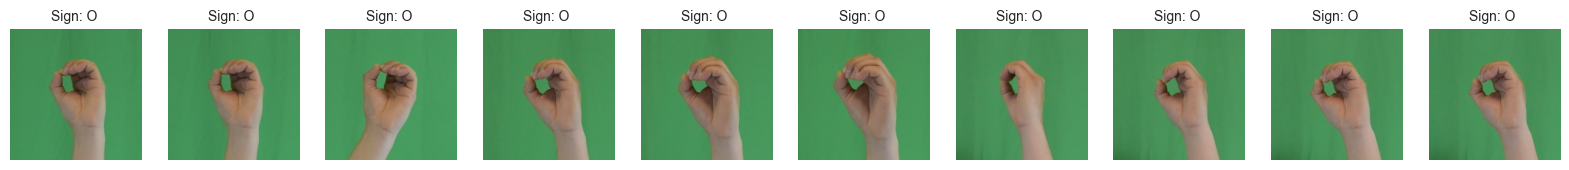

In [175]:
sign='O'
view_img(sign)

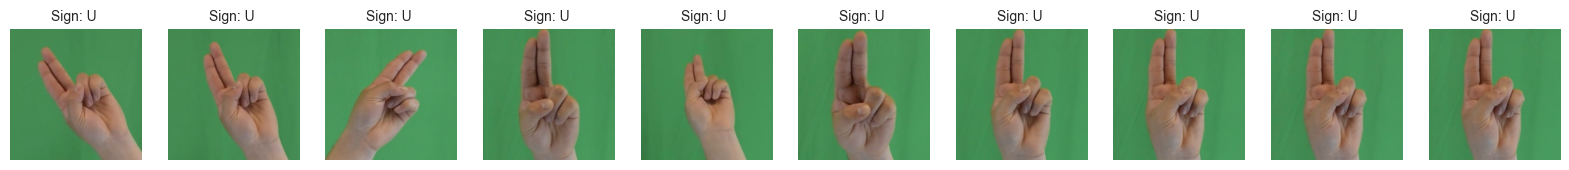

In [176]:
sign='U'
view_img(sign)

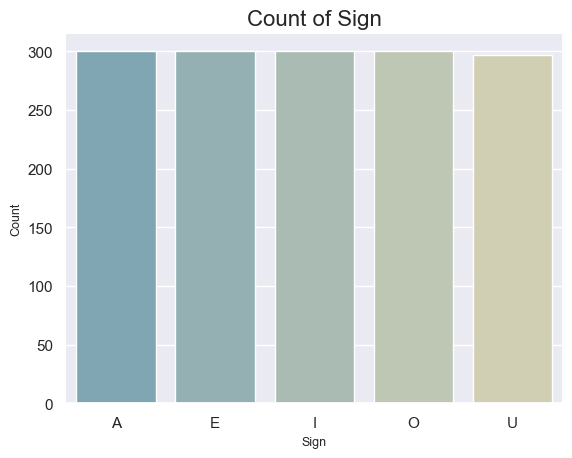

In [177]:
dataPath = pd.concat([dataset_df], axis = 0)
plt.title('Count of Sign', size=16)
sns.set_theme(palette="blend:#7AB,#EDA")
sns.countplot(x=dataPath["Sign"])
plt.xlabel('Sign', size=9)
plt.ylabel('Count', size=9)
sns.despine(top=True, right=True, left=True, bottom=False)
plt.show()

## Data processing

In [178]:
count_sign = dataset_df.groupby('Sign').count().reset_index()
sign = np.array(count_sign['Sign'])

mpHands = mp.solutions.hands
hands = mpHands.Hands(max_num_hands=2)
df = pd.DataFrame()

for path, sign in zip(tqdm_notebook(dataset_df.Path), dataset_df.Sign): 
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img_np = np.array(img)
    h, w, c = img_np.shape
    img = cv2.flip(img, 1)
    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    results = hands.process(imgRGB)

    hand_landmarks = results.multi_hand_landmarks
    landmarks = np.zeros((21, 3))
    landmarks_array=([])
    for idx, landmark in enumerate(hand_landmarks[0].landmark):
        landmarks[idx] = [landmark.x, landmark.y, landmark.z]
        landmarks_array = np.append(landmarks_array, landmarks[idx])
   
    landmarks_array = np.append(landmarks_array, sign)
    df = pd.concat([df, pd.DataFrame(landmarks_array).T], axis=0)

  0%|          | 0/1497 [00:00<?, ?it/s]

## Data Preparation

### Normalize data

In [179]:
# scaling our data with sklearn's Standard scaler
X = df.iloc[:, 0:62]
Y = df.iloc[:, 63]

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [180]:
len(X), len(Y), dataPath.Path.shape  

(1497, 1497, (1497,))

### Splitting data

In [181]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0, shuffle=True)

### Initialize model, Training and Predicting

In [184]:
# Initialize the Multilayer-Perceptron Classifier
model = MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(400,), learning_rate='adaptive', max_iter=1000)

# Training the model
model.fit(X_train,Y_train)

# Predicting for the test set
Y_pred = model.predict(X_test)

### Confusion matrix and metrics

              precision    recall  f1-score   support

           A       1.00      1.00      1.00        70
           E       1.00      1.00      1.00        69
           I       1.00      1.00      1.00        81
           O       1.00      1.00      1.00        73
           U       1.00      1.00      1.00        82

    accuracy                           1.00       375
   macro avg       1.00      1.00      1.00       375
weighted avg       1.00      1.00      1.00       375



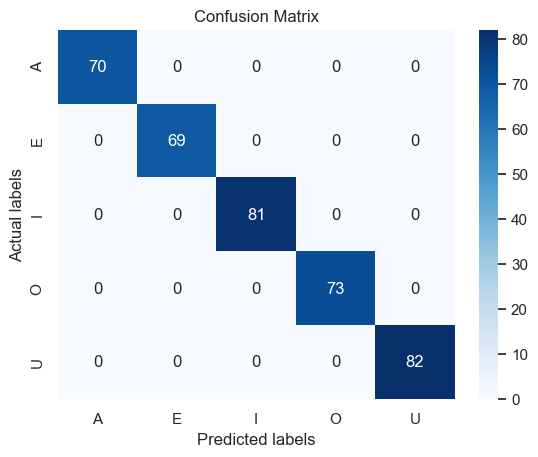

In [186]:
ax= plt.subplot()
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap = 'Blues', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Actual labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(count_sign.Sign)
ax.yaxis.set_ticklabels(count_sign.Sign);

# metrics
print(classification_report(Y_test, model.predict(X_test)))

## Leave-One-Out Cross-Validation

In [190]:
Xx = np.array(X)
Yy = np.array(Y)

# Models to test
models = [model]

# Initialize LOOCV
loo = LeaveOneOut()

model_results = []

for train_index, test_index in tqdm_notebook(loo.split(Xx,Yy)):
    # Train and test data
    Xx_train, Xx_test = Xx[train_index], Xx[test_index]
    Yy_train, Yy_test = Yy[train_index], Yy[test_index]

    # Training
    model.fit(Xx_train, Yy_train)

    # Evaluating the model with test data
    score = model.score(Xx_test, Yy_test)

    model_results.append(score)

# Average prediction error
error = 1 - sum(model_results) / len(model_results)
print(error)

0.0


## Re-training the model

In [193]:
# Initialize the Multilayer-Perceptron Classifier
model_re = MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(400,), learning_rate='adaptive', max_iter=1000)

# Re-training the model
X_re = scaler.fit_transform(X)
Y_re = Y
model_re.fit(X,Y)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(400,),
              learning_rate='adaptive', max_iter=1000)

In [204]:
#Saving the model
import pickle
# Save the Modle to file in the current working directory
#For any new testing data other than the data in dataset

Pkl_Filename = "Hand_Gesture_Detection_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model_re, file)

In [206]:
# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:  
    Hand_Gesture_Detection_Model = pickle.load(file)

Hand_Gesture_Detection_Model

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(400,),
              learning_rate='adaptive', max_iter=1000)

## Loading data validation

In [214]:
# Root folder where to look for jpg files
root_folder_v = ".\dataset_validation"

# Pattern to search for jpg files in all subdirectories
pattern_v = os.path.join(root_folder_v, "*.jpg")

# Search for files matching the pattern
jpg_files_v = glob.glob(pattern_v, recursive=True)

file_sign_label_v = []
file_sign_path_v = []

# Paths and labels to the files found
for path_v in tqdm_notebook(jpg_files_v):
    part_v = os.path.basename(path_v)
    part_v = part_v.split('.')[0]  
    label_v = part_v.split('-')[0]
    file_sign_label_v.append(label_v)
    file_sign_path_v.append(path_v)    

# Creating dataframe
sign_df_v = pd.DataFrame(file_sign_label_v, columns=['Sign'])
path_df_v = pd.DataFrame(file_sign_path_v, columns=['Path'])
dataset_df_v = pd.concat([sign_df_v, path_df_v], axis = 1) 



  0%|          | 0/42 [00:00<?, ?it/s]

In [216]:
# Characteristics
count_sign = dataset_df_v.groupby('Sign').count().reset_index()
sign = np.array(count_sign['Sign'])

mpHands = mp.solutions.hands
hands = mpHands.Hands(max_num_hands=2)
df = pd.DataFrame()

for path, sign in zip(tqdm_notebook(dataset_df_v.Path), dataset_df_v.Sign): 
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img_np = np.array(img)
    h, w, c = img_np.shape
    img = cv2.flip(img, 1)
    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    results = hands.process(imgRGB)

    hand_landmarks = results.multi_hand_landmarks
    landmarks = np.zeros((21, 3))
    landmarks_array=([])
    for idx, landmark in enumerate(hand_landmarks[0].landmark):
        landmarks[idx] = [landmark.x, landmark.y, landmark.z]
        landmarks_array = np.append(landmarks_array, landmarks[idx])
   
    landmarks_array = np.append(landmarks_array, sign)
    df = pd.concat([df, pd.DataFrame(landmarks_array).T], axis=0)

  0%|          | 0/42 [00:00<?, ?it/s]

In [217]:
# scaling our data with sklearn's Standard scaler
X_new = df.iloc[:, 0:62]
Y_new = df.iloc[:, 63]

scaler = StandardScaler()
X_new_norm = scaler.fit_transform(X_new)

In [219]:
# Evaluating model    
pred = Hand_Gesture_Detection_Model.predict(X_new_norm)

              precision    recall  f1-score   support

           A       0.00      0.00      0.00         9
           E       0.00      0.00      0.00         9
           I       0.29      1.00      0.44         8
           O       0.40      0.29      0.33         7
           U       1.00      1.00      1.00         9

    accuracy                           0.45        42
   macro avg       0.34      0.46      0.36        42
weighted avg       0.34      0.45      0.35        42



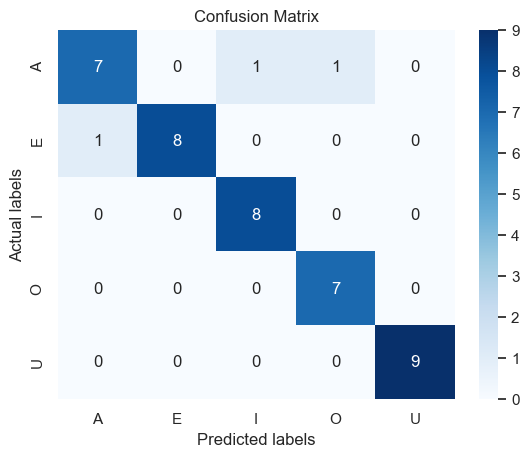

In [222]:
ax= plt.subplot()
cm = confusion_matrix(Y_new, pred)
sns.heatmap(cm, annot=True, fmt='g', cmap = 'Blues', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Actual labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(count_sign.Sign)
ax.yaxis.set_ticklabels(count_sign.Sign);

# metrics
print(classification_report(Y_new, Hand_Gesture_Detection_Model.predict(X_new)))